In [53]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV



In [54]:
train_X_with_vessel_ID = pd.read_csv('data/processed_data/train_X_with_vessel_ID.csv')
train_y = pd.read_csv('data/processed_data/train_y.csv')

train_X = train_X_with_vessel_ID.drop(["vesselId"], axis=1)

xgb_latitude = xgb.XGBRegressor()
xgb_longitude = xgb.XGBRegressor()

train_X.head()

,time,last_known_latitude,last_known_longitude,time_of_last_known_position,week_of_the_year,day_of_the_year
0,0.031707,7.50361,77.58340,0.031663,0.019231,0.030137
1,0.031757,7.57302,77.49505,0.031707,0.019231,0.030137
2,0.031798,7.65043,77.39404,0.031757,0.019231,0.030137
3,0.031838,7.71275,77.31394,0.031798,0.019231,0.030137
4,0.031866,7.77191,77.23585,0.031838,0.019231,0.030137


In [65]:

param_grid = {
    'n_estimators': [100, 200, 300, 500, 1000],
    'max_depth': [3, 6, 9, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}



GS_lat = GridSearchCV(
    estimator=xgb_latitude,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    refit="neg_root_mean_squared_error",
    cv=5,
    verbose=4
)

GS_long = GridSearchCV(
    estimator=xgb_longitude,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    refit="neg_root_mean_squared_error",
    cv=5,
    verbose=4
)

GS_lat.fit(train_X, train_y['latitude'])
GS_long.fit(train_X, train_y['longitude'])


best_params_lat = GS_lat.best_params_
best_params_long = GS_long.best_params_

print(f"Best params for lat model: {best_params_lat}")
print(f"Best params for long model: {best_params_long}")




Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-10.468 total time=   1.2s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-9.148 total time=   1.1s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-7.570 total time=   1.1s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-9.327 total time=   1.1s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-7.270 total time=   1.1s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=-4.240 total time=   2.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=-3.847 total time=   1.9s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=-3.146 total time=   2.1s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=-4.243 total time=   2.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=200;,

In [59]:
xgb_latitude_best_params = {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000}
xgb_longitude_best_params = {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 500}


xgb_latitude.set_params(**xgb_latitude_best_params)
xgb_longitude.set_params(**xgb_longitude_best_params)


# Train the model for latitude
xgb_latitude.fit(train_X, train_y['latitude'])
pred_lat = xgb_latitude.predict(train_X)

pred_lat_series = pd.Series(pred_lat, index=train_X.index, name='predicted_latitude')

train_X_with_lat = pd.concat([train_X, pred_lat_series],axis=1)

# Train the model for longitude
xgb_longitude.fit(train_X_with_lat, train_y['longitude'])

pred_lon = xgb_longitude.predict(train_X_with_lat)



# Evaluate performance using Mean Squared Error (MSE)
rmse_latitude = root_mean_squared_error(train_y['latitude'], pred_lat)
rmse_longitude = root_mean_squared_error(train_y['longitude'], pred_lon)

print(f"Validation RMSE for Latitude: {rmse_latitude}")
print(f"Validation RMSE for Longitude: {rmse_longitude}")


Validation RMSE for Latitude: 0.6295323568708729
Validation RMSE for Longitude: 0.9915207339498259


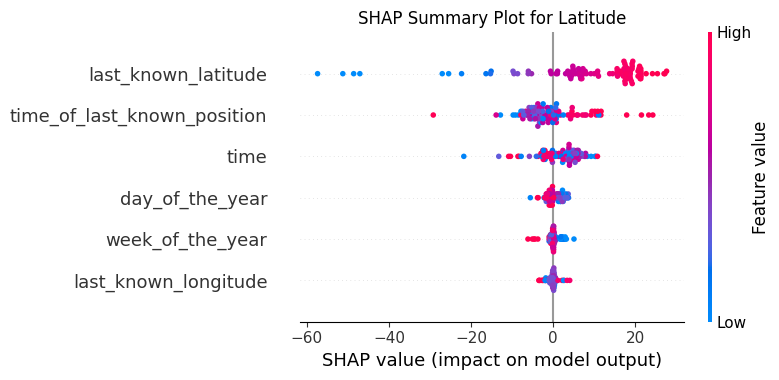

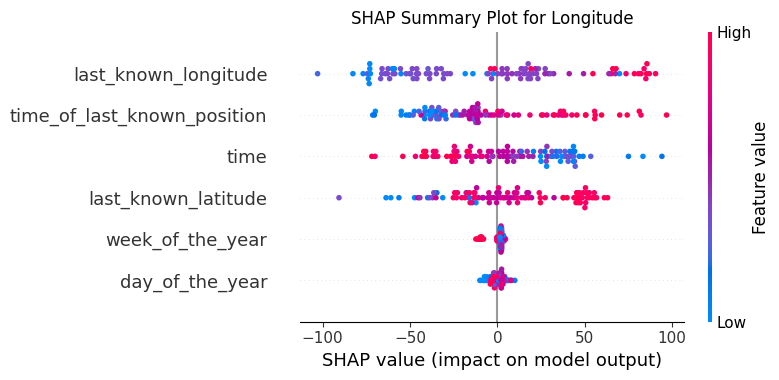

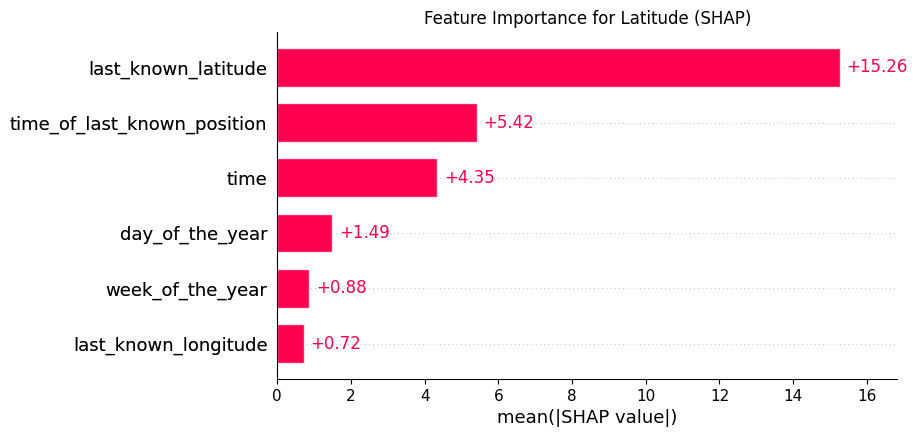

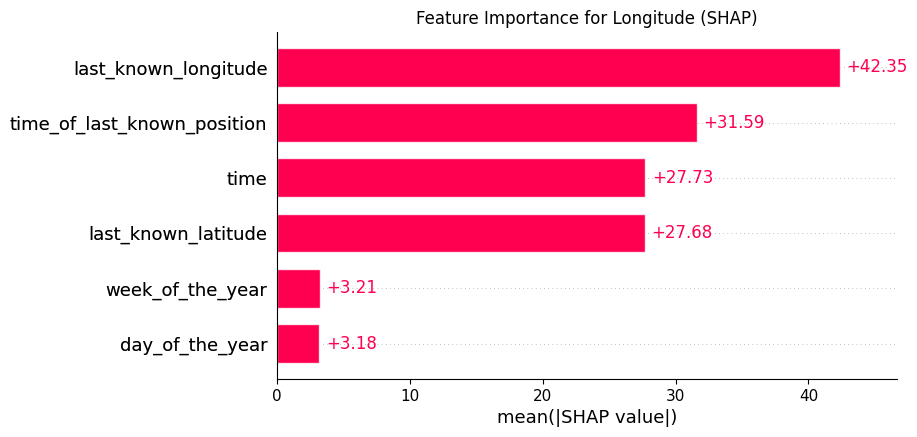

In [51]:
import shap
import matplotlib.pyplot as plt

background_data = train_X.sample(n=100, random_state=42)
shap_data = train_X.sample(n=100, random_state=28)

# SHAP explainer for latitude model
explainer_latitude = shap.Explainer(xgb_latitude, background_data)
shap_values_latitude = explainer_latitude(shap_data)

# SHAP explainer for longitude model
explainer_longitude = shap.Explainer(xgb_longitude, background_data)
shap_values_longitude = explainer_longitude(shap_data)

# SHAP summary plot for Latitude predictions
plt.title("SHAP Summary Plot for Latitude")
shap.summary_plot(shap_values_latitude, shap_data)
plt.show()

# SHAP summary plot for Longitude predictions
plt.title("SHAP Summary Plot for Longitude")
shap.summary_plot(shap_values_longitude, shap_data)
plt.show()

# Global feature importance for Latitude model
plt.title("Feature Importance for Latitude (SHAP)")
shap.plots.bar(shap_values_latitude)
plt.show()

# Global feature importance for Longitude model
plt.title("Feature Importance for Longitude (SHAP)")
shap.plots.bar(shap_values_longitude)
plt.show()


In [57]:


# Assuming xgb_longitude and xgb_latitude are already loaded pre-trained models
# For example:
# import joblib
# xgb_longitude = joblib.load('models/xgb_longitude.joblib')
# xgb_latitude = joblib.load('models/xgb_latitude.joblib')

expected_features = ['time', 'last_known_latitude', 'last_known_longitude', 'time_of_last_known_position', 'week_of_the_year', 'day_of_the_year']


# Load test data
test_X = pd.read_csv('data/processed_data/test.csv')
test_X = test_X.drop(["scaling_factor"], axis=1)
test_X["last_known_latitude"] = np.nan
test_X["last_known_longitude"] = np.nan
test_X["time_of_last_known_position"] = np.nan

# Sort training data and extract last known positions
train_X_with_vessel_ID = train_X_with_vessel_ID.sort_values(by=['vesselId', 'time'])

last_known_positions = train_X_with_vessel_ID.groupby('vesselId').agg({
    'last_known_latitude': 'last',
    'last_known_longitude': 'last',
    'time_of_last_known_position': 'last'
}).reset_index()

# Convert to dictionary for quick lookup
last_known_dict = last_known_positions.set_index('vesselId').to_dict('index')

# Initialize a list to store results
results_list = []

# Initialize tqdm progress bar
with tqdm(total=len(test_X), unit="row", desc="Making Predictions") as pbar:

    unique_vessel_ids = test_X["vesselId"].unique()

    for vessel_id in unique_vessel_ids:
        # Filter rows for the current vessel_id and reset index
        df = test_X[test_X["vesselId"] == vessel_id].reset_index(drop=True)

        # Iterate using itertuples for better performance
        for row in df.itertuples(index=True):
            idx = row.Index
            vessel_ID = row.vesselId
            row_ID = row.ID
            current_time = row.time

            # Retrieve last known position
            last_position = last_known_dict.get(vessel_ID, {
                'last_known_latitude': np.nan,
                'last_known_longitude': np.nan,
                'time_of_last_known_position': np.nan
            })

            last_lat = last_position['last_known_latitude']
            last_lon = last_position['last_known_longitude']
            last_time = last_position['time_of_last_known_position']

            if idx == 0:
                # Assign last known positions from training data
                test_X.at[row.Index, "last_known_longitude"] = last_lon
                test_X.at[row.Index, "last_known_latitude"] = last_lat
                test_X.at[row.Index, "time_of_last_known_position"] = last_time

                # Prepare feature vector for prediction based on last known positions
                feature_vector = test_X.loc[row.Index, expected_features].to_frame().T


                # Make predictions
                pred_lat = xgb_latitude.predict(feature_vector)[0]
                feature_vector['predicted_latitude'] = pred_lat

                pred_lon = xgb_longitude.predict(feature_vector)[0]

                # Append prediction to results list with current row's ID
                results_list.append({
                    "ID": row_ID,
                    "longitude_predicted": pred_lon,
                    "latitude_predicted": pred_lat
                })

                # Update current row with predictions
                test_X.at[row.Index, "last_known_longitude"] = pred_lon
                test_X.at[row.Index, "last_known_latitude"] = pred_lat
                test_X.at[row.Index, "time_of_last_known_position"] = current_time

                # Update tracking dictionary with new predictions if not NaN
                if not pd.isna(pred_lat) and not pd.isna(pred_lon):
                    last_known_dict[vessel_ID] = {
                        'last_known_latitude': pred_lat,
                        'last_known_longitude': pred_lon,
                        'time_of_last_known_position': current_time
                    }

            else:
                # Prepare feature vector for prediction based on previous row
                previous_row = test_X.iloc[row.Index - 1][expected_features].to_frame().T


                # Make predictions
                pred_lat = xgb_latitude.predict(previous_row)[0]

                previous_row['predicted_latitude'] = pred_lat
                pred_lon = xgb_longitude.predict(previous_row)[0]

                # Append prediction to results list with current row's ID
                results_list.append({
                    "ID": row_ID,
                    "longitude_predicted": pred_lon,
                    "latitude_predicted": pred_lat
                })

                # Update current row with predictions
                test_X.at[row.Index, "last_known_longitude"] = pred_lon
                test_X.at[row.Index, "last_known_latitude"] = pred_lat
                test_X.at[row.Index, "time_of_last_known_position"] = test_X.at[row.Index - 1, "time"]

                # Update tracking dictionary with new predictions if not NaN
                if not pd.isna(pred_lat) and not pd.isna(pred_lon):
                    last_known_dict[vessel_ID] = {
                        'last_known_latitude': pred_lat,
                        'last_known_longitude': pred_lon,
                        'time_of_last_known_position': test_X.at[row.Index - 1, "time"]
                    }

            # Update the progress bar
            pbar.update(1)

# Convert the results list to a DataFrame and sort by ID
results = pd.DataFrame(results_list).sort_values(by=['ID'])

# Save predictions to CSV
results.to_csv("data/results.csv", index=False)


Making Predictions: 100%|██████████| 51739/51739 [01:12<00:00, 716.69row/s]
